Pengujian Model

In [1]:
#import libraries and packages

from numpy.random import seed
seed(8) #1

import tensorflow
tensorflow.random.set_seed(7)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

from tensorflow.keras import backend as K
from tensorflow.keras.models import Model ,load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import tensorflow as tf

from tensorflow.python.keras import models
from tensorflow.python.keras import layers

from tensorflow.keras import optimizers

In [2]:
# model summary
model = load_model('../Coding/4-class-DumpTruck.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dropout (Dropout)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 256)               13107456  
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 33969964 (129.59 MB)
Trainable params: 33915436 (129.38 MB)
Non-trainable params: 54528 (213.00 KB)
_________________________________________________________________


In [3]:
# model evaluation menggunakan dataset test

import cv2

def convert_and_light_normalization(input_folder_path, output_folder_path):
    for label_folder in os.listdir(input_folder_path):
        label_folder_path = os.path.join(input_folder_path, label_folder)
        output_label_folder_path = os.path.join(output_folder_path, label_folder)
        
        if os.path.isdir(label_folder_path):
            os.makedirs(output_label_folder_path, exist_ok=True)  # Membuat folder output jika belum ada
            
            for image_file in os.listdir(label_folder_path):
                image_path = os.path.join(label_folder_path, image_file)
                
                if image_file.endswith('.jpg') or image_file.endswith('.png') or image_file.endswith('.jpeg'):  # Pastikan hanya membaca file gambar
                    img = cv2.imread(image_path)
                    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    
                    # Normalisasi pencahayaan menggunakan CLAHE (Contrast Limited Adaptive Histogram Equalization)
                    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
                    normalized_img = clahe.apply(gray_img)
                    
                    output_image_path = os.path.join(output_label_folder_path, image_file)
                    cv2.imwrite(output_image_path, normalized_img)

IMAGE_SIZE    = (150, 150)
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_dir =  '../Dataset/Test'
output_test_dir = '../DatasetOut/Test'

convert_and_light_normalization(test_dir, output_test_dir)

eval_generator = test_datagen.flow_from_directory(output_test_dir,target_size=IMAGE_SIZE,batch_size=1, 
                                                  shuffle=False, seed=42, class_mode="categorical")
eval_generator.reset()  

Found 8 images belonging to 4 classes.


In [4]:
# Prediksi menggunakan model pada dataset test

IMAGE_SIZE    = (150, 150)
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_dir =  '../DatasetOut/Test'

pred_generator = test_datagen.flow_from_directory(
        test_dir,target_size=IMAGE_SIZE,
        batch_size=1,
        shuffle=False,
        
        seed=42,
        
        class_mode="categorical")
pred_generator.reset()   

count=[0,0,0,0]

files=pred_generator.filenames

for i in range(len(files)):
  x,y = pred_generator.next()
  img = x
  predict=model.predict(img)
  
  p=np.argmax(predict, axis=-1)
  print(str(p[0])+" "+files[pred_generator.batch_index-1])
  #print(predict)
  #p=model.predict_classes(img)
  count[p[0]]+=1
  
#print(str(p[0])+" "+files[i]) 
print(count)

Found 8 images belonging to 4 classes.


1/1 [==============================] - 2s 2s/step
0 Kusam\7.jpg
1/1 [==============================] - 0s 94ms/step
0 Kusam\8.jpg
1/1 [==============================] - 0s 94ms/step
1 Normal\8.jpg
1/1 [==============================] - 0s 100ms/step
1 Normal\9.jpeg
1/1 [==============================] - 0s 94ms/step
2 Retak\7.jpg
1/1 [==============================] - 0s 94ms/step
2 Retak\8.jpg
1/1 [==============================] - 0s 102ms/step
2 Tergores\7.jpg
1/1 [==============================] - 0s 109ms/step
2 Tergores\8.jpg
[2, 2, 4, 0]


C:\Users\Imam Maskuri\AppData\Local\Temp\ipykernel_20948\384991685.py:10: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(eval_generator, steps=np.ceil(len(eval_generator)))


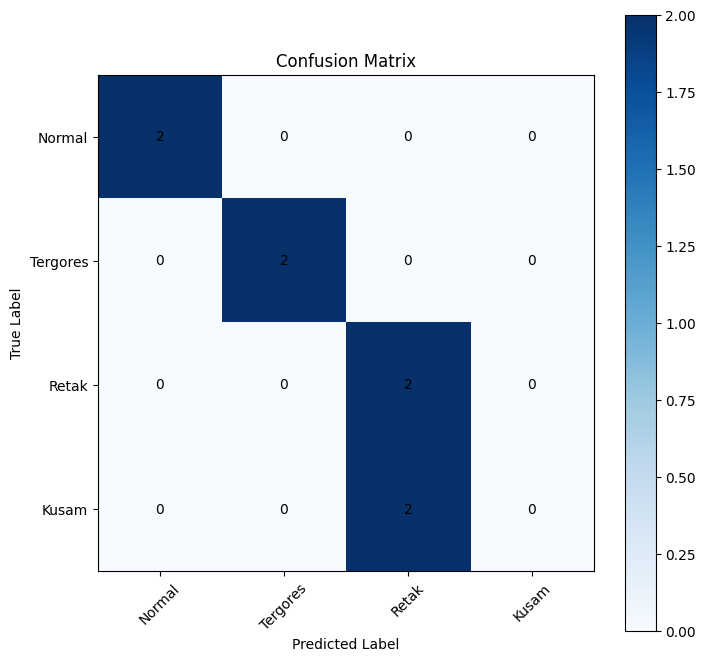

In [5]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np


# Menghitung prediksi menggunakan model
filenames = eval_generator.filenames
nb_samples = len(filenames)
eval_generator.reset()  
predict = model.predict_generator(eval_generator, steps=np.ceil(len(eval_generator)))
pp = predict

# Mendapatkan label sebenarnya dan prediksi kelas
true_labels = eval_generator.classes
predicted_labels = np.argmax(pp, axis=1)

# Menghitung matriks konfusi
cm = confusion_matrix(true_labels, predicted_labels)

# Menampilkan laporan klasifikasi
class_names = ["Normal", "Tergores", "Retak", "Kusam"]

# Menampilkan matriks konfusi secara manual
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, str(cm[i, j]), horizontalalignment='center', verticalalignment='center')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



In [6]:
# hitung MSE, RMSE, dan MAE

from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

print("MSE  : ", mean_squared_error(true_labels, predicted_labels))
print("RMSE : ", sqrt(mean_squared_error(true_labels, predicted_labels)))
print("MAE  : ", mean_absolute_error(true_labels, predicted_labels))

MSE  :  0.25
RMSE :  0.5
MAE  :  0.25
